## Constructing Zone 7 Load Profiles

*raw_csv* contains the following data: 
- Consumers Energy 2019 8760-hour load profile
- DTE 2018 8760-hour load profile
- DTW 2019 8760-hour load profile

Each file contains the load broken down by customer class and rate. 

My goal is to construct a 2019 8760-hour load profile for MISO Zone 7, whose shape we assume will be well-approximated by combining the 2019 Consumers Energy data with the 2019 DTE data, since these two utilities make up around 90% of the total load in zone 7. The rest is made up from many smaller utilities whose load profiles (we assume) will not dramatically affect the shape. We'll get the overall load for Zone 7 by scaling the 90% up to 100%. 

Later, we will use the 2018 and 2019 data from DTE to inform our construction of a load profile for Ann Arbor. This will be trickier, since the customer class breakdown for Ann Arbor will be different from DTE as a whole. 

___

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from helper_functions import make_timestamp, hour_from_timestamp, convert_energy_number_to_int

### Get data from raw_csv (raw data from rate cases) and create an 8760-hour load profile for CE & DTE

In [ ]:
# paths to raw csv files
ce_2019 = 'raw_csv/ce-2019-by-class.csv'
dte_2018 = 'raw_csv/dte-2018-by-class.csv'
dte_2019 = 'raw_csv/dte-2019-by-class.csv'

# pick current file
current_csv = dte_2019

In [406]:
# create df and timestamp column
df = pd.read_csv(current_csv)
df.insert(
    loc=0
    , column='Timestamp'
    , value=df.apply(lambda row: make_timestamp(2019, row['Month'], row['Day'], row['Hour']), axis=1)
)
df_has_been_transformed = False

In [418]:
# drop timestamp elements and create hour column mapping a timestamp to an hour from 1 to 8760
if not df_has_been_transformed: 
    df = df.drop(['Month', 'Day', 'Hour'], axis=1)
    if 'Year' in df.columns: 
        df = df.drop(['Year'], axis=1)
    df.insert(
        loc=1
        , column='Hour'
        , value=df.Timestamp.apply(hour_from_timestamp)
    )
    # convert kwh column into a usable integer
    if 'Kwh' in df.columns: 
        df.Kwh = df.Kwh.apply(convert_energy_number_to_int)
        df = df.rename({'Kwh': 'CE 2019 kWh'}, axis=1)
    elif '2019 kwh' in df.columns: 
        df['2019 kwh'] = df['2019 kwh'].apply(convert_energy_number_to_int)
        df = df.rename({'2019 kwh': 'DTE 2019 kWh'}, axis=1)
    df_has_been_transformed = True

# result
df

,Timestamp,Hour,Class,Rate,DTE 2019 kWh
0,2019-01-01 00:00:00,1,RA-Residential,D1,34.36
1,2019-01-01 01:00:00,2,RA-Residential,D1,35.67
2,2019-01-01 02:00:00,3,RA-Residential,D1,31.71
3,2019-01-01 03:00:00,4,RA-Residential,D1,33.62
4,2019-01-01 04:00:00,5,RA-Residential,D1,31.15
...,...,...,...,...,...
486995,2019-12-31 19:00:00,8756,Secondary,RDG,169.03
486996,2019-12-31 20:00:00,8757,Secondary,RDG,172.34
486997,2019-12-31 21:00:00,8758,Secondary,RDG,171.72
486998,2019-12-31 22:00:00,8759,Secondary,RDG,171.38


### Group different classes together by hour to create the total load profile for CE & DTE

In [371]:
# change column either to DTE 2019 kWh or CE 2019 kWh
grouped = df.groupby(by='Hour')[['DTE 2019 kWh']].sum()
grouped

,DTE 2019 kWh
Hour,
1,4295735.29
2,4158898.77
3,4038122.58
4,3955289.62
5,3921134.33
...,...
8756,5118314.14
8757,4972211.07
8758,4834341.66


In [372]:
# save to csv if it doesn't exist yet
if current_csv == ce_2019: 
    new_file = 'ce-2019-total.csv'
elif current_csv == dte_2019: 
    new_file = 'dte-2019-total.csv'
grouped.to_csv(f'zone-7-data/{new_file}')

### troubleshooting - DTE is missing 2019-03-10 02:00:00

DTE has no data for hour 1635 of the year, or 2019-03-10 02:00:00

To do: 
- &check; look for anomalously high load hour in DTE at DLS crossover in the fall
    - result: DTE is simply missing 1635, and doesn't make up for it by duplicating the DLS hour in the fall (around hour 7300-7400)
- &check; fill in missing hour either by interpolating, or by splitting an existing hour in half at the crossover
    - result: missing hour is filled in using linear interpolation 

In [ ]:
df_dte = pd.read_csv('zone-7-data/dte-2019-total.csv')
df_ce = pd.read_csv('zone-7-data/ce-2019-total.csv')

# fill in the missing hour for DTE
if len(df_dte.loc[df_dte['Hour'] == 1635]) == 0: 
    df_dte.loc[-1, 'Hour'] = 1635
    df_dte = df_dte.sort_values('Hour').reset_index(drop=True)
    df_dte = df_dte.interpolate()

### Get total load for zone 7
In *raw_csv/eia-861-mi-sales-by-utility*, we have a list of the utilities in Michigan and a column for whether they are part of MISO Zone 7 (courtesy of Douglas). 

We will first filter out the ones not in Zone 7 and then add up the total sales (in MWh) to obtain the total load for zone 7. 

The catch: some of the utilities have overlapping sales—ones whose Service Type is "Energy" sell energy to their customers, but they may offload the delivery servcice onto another utility (usually DTE or Consumers). Conversely, energy sold by a "Delivery" Service Type utility indicates an amount delivered in the service territory of said utility, but not generated by assets through which it sells generation. To avoid overcounting, we can either exclude the "Energy" Service Type utilities or the ones with "Delivery" type. 

Douglas expects that the sum excluding the "Delivery" service type will slightly exceed the sum excluding the "Energy" service type, since some of the "Energy" service type utilities sell energy outside Zone 7, but the Delivery rows are all in zone 7. 

To do: 
- &check; Load the eia-861 csv as a df and filter out the ones not in Zone 7. 
- &check; Write code to toggle the following: 
    - &check; whether to exclude Delivery Service Type utilities or Energy Service Type utilities
    - &check; whether to include Greenskies Renewable Energy (it's not clear whether it's in Zone 7 or not; it appears to be a solar company in CT
- &check; Check Douglas' hunch that excluding Delivery yields a higher total overall load than excluding Energy
- &check; Compare the DTE & Consumers sums to the overall load from EIA (sanity check)
- &check; Sum the CE + DTE load profiles over the year and compare to Zone 7 total 
- &check; use the ratio (Zone 7)/(CE + DTE) to scale up the load profile of the sum to get overall Zone 7 load profile
- make plots

In [606]:
# toggle these
drop_greenskies = False
exclude = 'Energy' # Energy or Delivery

# load EIA csv & filter to zone 7
df_eia = pd.read_csv('raw_csv/eia-861-mi-sales-by-utility.csv', header=2)
df_eia_zone_7 = df_eia.loc[df_eia['Is In Zone 7?'] == 'y']

# filter according to toggle settings above
if drop_greenskies: 
    df_eia_zone_7 = df_eia_zone_7.loc[df_eia_zone_7['Utility Name'] != 'Greenskies Renewable Energy, LLC']
if exclude == 'Energy': 
    df_eia_zone_7 = df_eia_zone_7.loc[df_eia_zone_7['Service Type'] != 'Energy']
elif exclude == 'Delivery': 
    df_eia_zone_7 = df_eia_zone_7.loc[df_eia_zone_7['Service Type'] != 'Delivery']
else: 
    assert False, 'If you fail to exclude either Delivery or Energy, you will overcount the load!'

# convert total sales from str with commas to int    
df_eia_zone_7['Total - Sales (MWh)'] = df_eia_zone_7['Total - Sales (MWh)'].apply(convert_energy_number_to_int)

eia_load = df_eia_zone_7['Total - Sales (MWh)'].sum()
print(f'Total Zone 7 Load from EIA is: {eia_load}')

Total Zone 7 Load from EIA is: 92494075.0


In [ ]:
# write the results to a text file if necessary
with open('zone-7-data/miso-zone-7-total-load.txt', 'a') as f: 
    f.write(f'Included greenskies: {not drop_greenskies}\nExcluded Energy or Delivery: {exclude}\n\t Total 2019 load: {eia_load}\n\n')

### Calculate the total load for both DTE & Consumers and for Zone 7
By excluding the Energy service type, we are dealing with only the sales that occur in zone 7, and it is indeed slightly lower than if we had excluded the Delivery service type. By excluding Energy and including Greenskies, the EIA total load for Zone 7 is 92,494,075 MWh

In [749]:
# make Zone 7 profile
df_zone_7 = pd.merge(df_dte, df_ce, how='inner')
df_zone_7['CE+DTE 2019 kWh'] = df_zone_7['DTE 2019 kWh'] + df_zone_7['CE 2019 kWh']

# get the CE + DTE sum & compare to EIA
ce_dte_sum = df_zone_7['CE+DTE 2019 kWh'].sum() / 1000 # kWh --> MWh
ce_dte_sum_eia = df_eia.loc[
    (df_eia['Utility Name'] == 'Consumers Energy Co') 
    | (df_eia['Utility Name'] == 'DTE Electric Company')
]
ce_dte_sum_eia = ce_dte_sum_eia['Total - Sales (MWh)'].apply(convert_energy_number_to_int).sum()
scale_factor = eia_load / ce_dte_sum 

print('Load values are expressed in MWh')
print(f'From the rate cases data, the total load is {ce_dte_sum}')
print(f'From EIA, the total load is {ce_dte_sum_eia}')
print(f'The error between these two is {round((ce_dte_sum_eia - ce_dte_sum)/ce_dte_sum_eia * 100, 1)}%')
print("We'll use the rate cases data to stay true to its representation of the load profile by the hour\n")
print(f'The total load from EIA is {eia_load}')
print(f'The total load differs from CE + DTE by a factor of {scale_factor}')
print(f'In other words, CE + DTE account for roughly {round(1/scale_factor * 100, 1)}% of the Zone 7 load')

Load values are expressed in MWh
From the rate cases data, the total load is 81176967.74386999
From EIA, the total load is 83096274.0
The error between these two is 2.3%
We'll use the rate cases data to stay true to its representation of the load profile by the hour

The total load from EIA is 92494075.0
The total load differs from CE + DTE by a factor of 1.1394127862947259
In other words, CE + DTE account for roughly 87.8% of the Zone 7 load


### Scale the DTE + CE sum by the overall load & plot

In [750]:
df_zone_7['Zone 7 Overall 2019 kWh'] = df_zone_7['CE+DTE 2019 kWh'] * scale_factor
df_zone_7.index = df_zone_7.Hour.apply(lambda x: int(x))
df_zone_7 = df_zone_7.drop('Hour', axis=1)
df_zone_7

,DTE 2019 kWh,CE 2019 kWh,CE+DTE 2019 kWh,Zone 7 Overall 2019 kWh
Hour,,,,
1,4295735.29,3115839.0,7411574.29,8.444843e+06
2,4158898.77,3025826.0,7184724.77,8.186367e+06
3,4038122.58,2945866.0,6983988.58,7.957646e+06
4,3955289.62,2899227.0,6854516.62,7.810124e+06
5,3921134.33,2900468.0,6821602.33,7.772621e+06
...,...,...,...,...
8756,5118314.14,4003834.0,9122148.14,1.039389e+07
8757,4972211.07,3901047.0,8873258.07,1.011030e+07
8758,4834341.66,3746298.0,8580639.66,9.776891e+06


In [654]:
# save to csv
df_zone_7.to_csv('zone-7-data/miso-zone-7-2019-total-load-profile.csv')

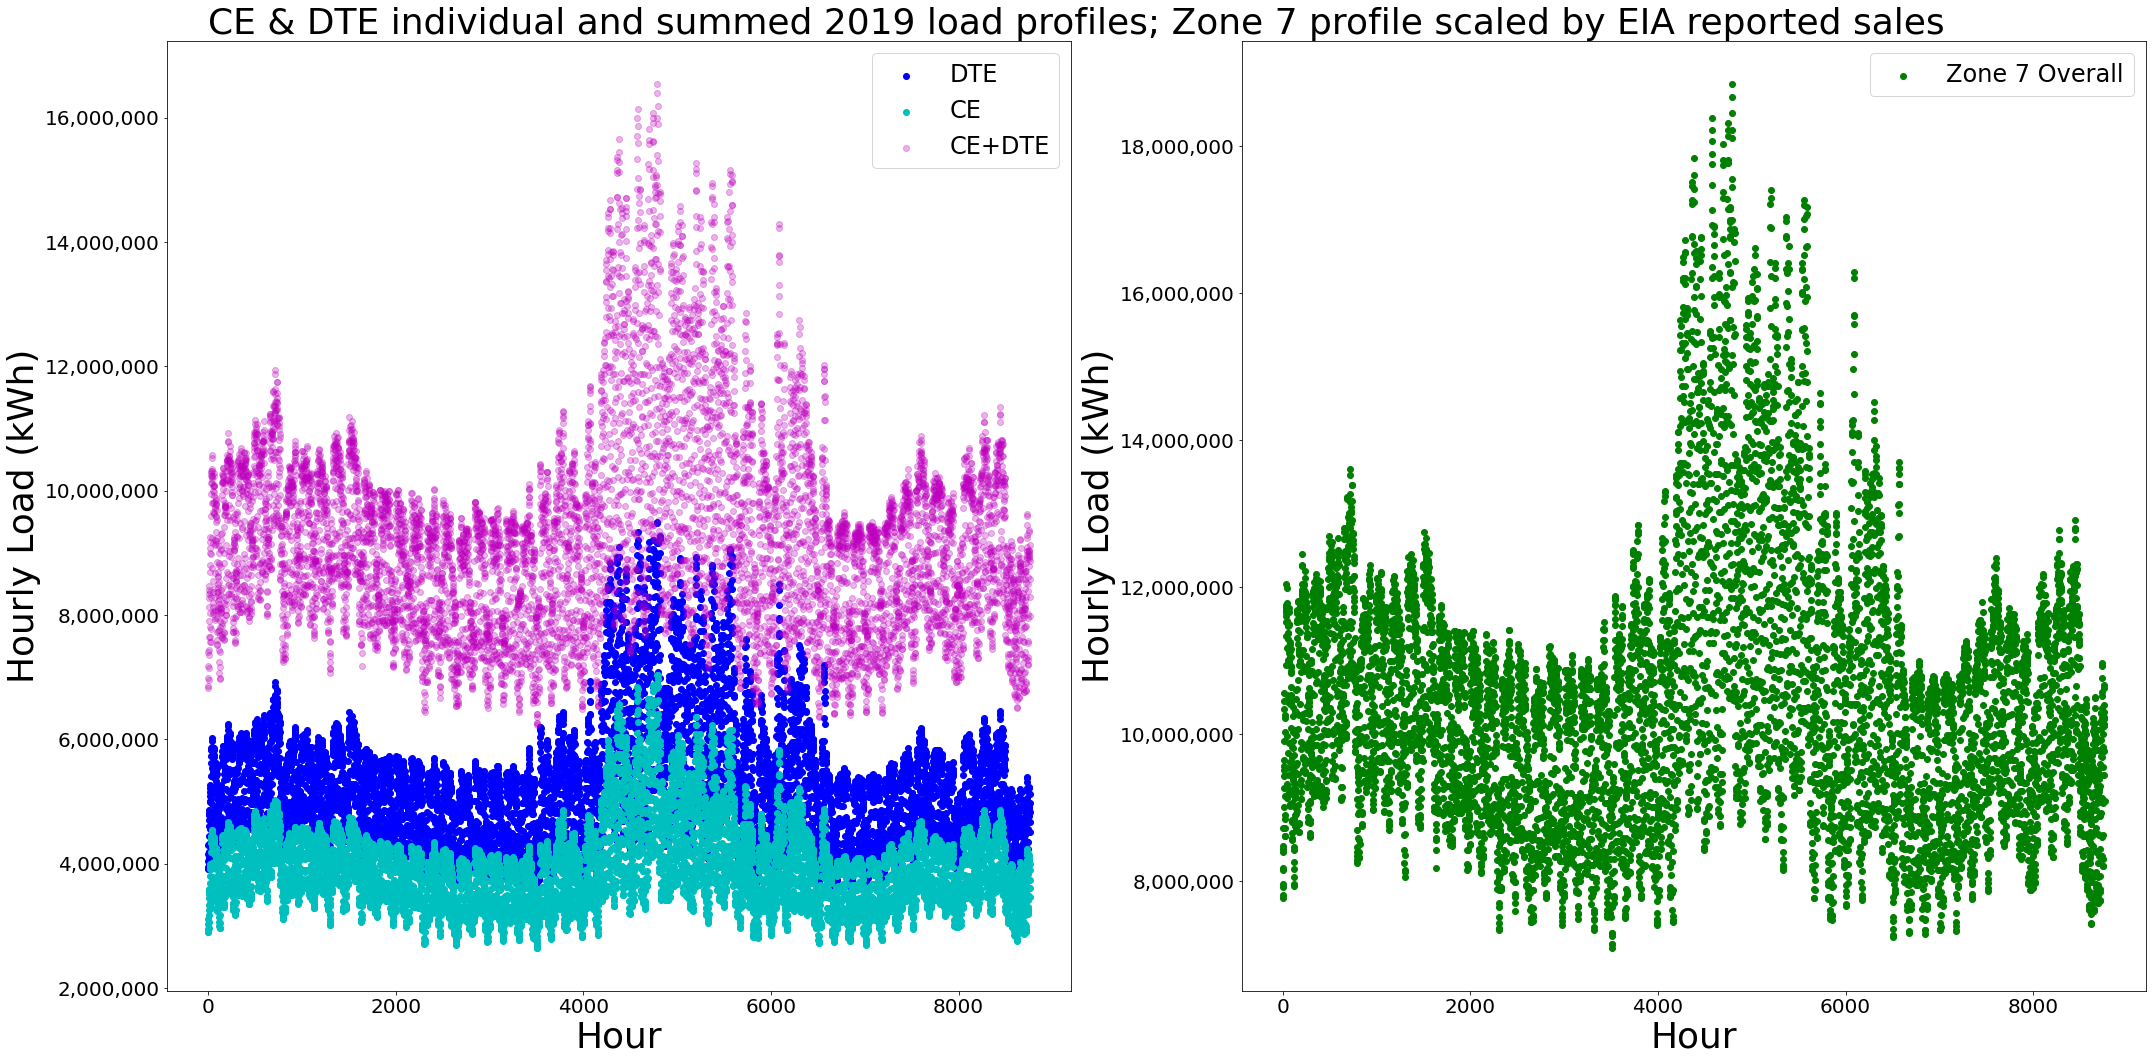

In [755]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

colors = ['b', 'c', 'm']
for i, col in enumerate(df_zone_7.columns[:-1]): 
    axes[0].scatter(
        x=df_zone_7.index
        , y=df_zone_7[col]
        , color=colors[i]
        , alpha=(0.3 if i==2 else 1)
        , label=col[:-9] # exclude '2019 kWh'
    )
axes[1].scatter(
    x=df_zone_7.index
    , y=df_zone_7['Zone 7 Overall 2019 kWh']
    , color='g'
    , label='Zone 7 Overall'
)

for ax in axes: 
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().set_major_formatter('{x:,.0f}')
    ax.tick_params(axis='both', which='major', labelsize=20)
    if ax == axes[0]: 
        ax.legend(fontsize=24)
    else: 
        ax.legend(fontsize=24)
    ax.set_xlabel('Hour', fontsize='36')
    ax.set_ylabel('Hourly Load (kWh)', fontsize='36')

fig.suptitle('CE & DTE individual and summed 2019 load profiles; Zone 7 profile scaled by EIA reported sales', fontsize=36)
fig.tight_layout()
plt.show()

In [756]:
# save the above figure
fig.savefig('zone-7-data/zone-7-2019-load-profile.jpg')